In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
from kuma_utils.stats import PropensityScoreMatching, make_demographic_table
from kuma_utils.preprocessing import PrepPipeline, SelectCategorical, SelectNumerical, DummyVarible, DistTransformer, Cast

In [3]:
from catboost.datasets import adult
train, test = adult()
full_dataset = pd.concat([train.assign(group='train'), test.assign(group='test')], axis=0)

# Make demopgraphic table (a.k.a. Table 1)
for numeric variables:
- run KS test
    - if the varible follows normal distribution, run T test
    - if no, run Mann Whitney U test
    
for categorical variables:
- run chi-squared test

In [4]:
full_dataset = full_dataset[
    ['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss', 'group']].copy().sample(10000)  # To make it simple

In [5]:
make_demographic_table(full_dataset, group_col='group', display_cols=full_dataset.columns, categorical_omission_count=10)

,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3352,6648,NaN
1,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,368 (11.0%),908 (13.7%),0.000170
2,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,414 (12.4%),838 (12.6%),0.740678
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,407 (12.1%),823 (12.4%),0.757067
4,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,427 (12.7%),747 (11.2%),0.030001
5,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,395 (11.8%),754 (11.3%),0.534310
6,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,345 (10.3%),633 (9.5%),0.234386
7,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,321 (9.6%),559 (8.4%),0.056315
8,"occupation=Machine-op-inspct, n(%)",categorical,NaN,Chi2,False,205 (6.1%),438 (6.6%),0.386198
9,"occupation=NaN, n(%)",categorical,NaN,Chi2,True,189 (5.6%),383 (5.8%),0.838491


# Propensity score matching
Matching methods
- Greedy: very slow
- Hungarian algorithm: very fast :)

In [11]:
psm_greedy = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'], 
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), DummyVarible(dummy_na=True)]),
    numerical_encoder=PrepPipeline([SelectNumerical(), DistTransformer('standard')]),
    matching_method='greedy')
make_demographic_table(
    psm_greedy.run(full_dataset), group_col='group', display_cols=full_dataset.columns, categorical_omission_count=5) #  ~60s

Logger created at 24/02/14:01:16:11
eval_metric automatically selected.
01:16:11 [None]	best score is 0.536432


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3348,3348,NaN
1,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,1337 (39.9%),1351 (40.4%),0.745866
2,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,427 (12.8%),420 (12.5%),0.825415
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,407 (12.2%),406 (12.1%),1.000000
4,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,395 (11.8%),415 (12.4%),0.476436
5,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,414 (12.4%),385 (11.5%),0.291176
6,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,368 (11.0%),371 (11.1%),0.937827
7,"education=HS-grad, n(%)",categorical,NaN,Chi2,False,1084 (32.4%),1091 (32.6%),0.875583
8,"education=Some-college, n(%)",categorical,NaN,Chi2,False,754 (22.5%),760 (22.7%),0.883865
9,"education=[education_other_categories], n(%)",categorical,NaN,Chi2,False,640 (19.1%),649 (19.4%),0.804160


In [10]:
psm_fast = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'],
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), DummyVarible(dummy_na=True)]),
    numerical_encoder=PrepPipeline([SelectNumerical(), DistTransformer('standard')]),
    matching_method='hungarian')
make_demographic_table(
    psm_fast.run(full_dataset), group_col='group', display_cols=full_dataset.columns, categorical_omission_count=5)  # ~0.5s

Logger created at 24/02/14:01:15:57
eval_metric automatically selected.
01:15:57 [None]	best score is 0.536432


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3349,3349,NaN
1,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,1338 (40.0%),1353 (40.4%),0.727144
2,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,427 (12.8%),420 (12.5%),0.825419
3,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,395 (11.8%),416 (12.4%),0.453791
4,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,407 (12.2%),402 (12.0%),0.880779
5,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,414 (12.4%),385 (11.5%),0.291186
6,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,368 (11.0%),373 (11.1%),0.876179
7,"education=HS-grad, n(%)",categorical,NaN,Chi2,False,1086 (32.4%),1095 (32.7%),0.834762
8,"education=Some-college, n(%)",categorical,NaN,Chi2,False,754 (22.5%),753 (22.5%),1.000000
9,"education=[education_other_categories], n(%)",categorical,NaN,Chi2,False,639 (19.1%),648 (19.3%),0.804054


# Feature importances for PSM model


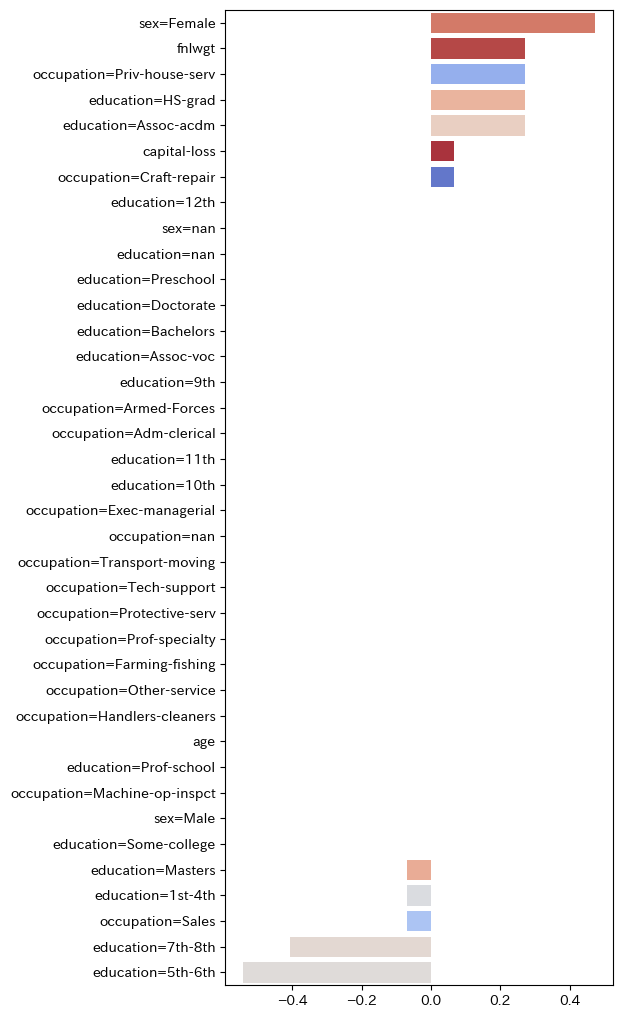

In [12]:
psm_fast.plot_feature_importance(full_dataset)

# PSM with GBDT
cross validation is supported!

In [13]:
psm_lgb = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'],
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), OrdinalEncoder()]),
    numerical_encoder=PrepPipeline([SelectNumerical()]),
    model=LGBMClassifier,
    trainer_params={
        'params': {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': 0,
        },
        'fit_params': {
            'num_boost_round': 500,
            'callbacks': [lgb.early_stopping(stopping_rounds=50, verbose=True), lgb.log_evaluation(25)]
        }
    },
    fit_method='cv',
    matching_method='hungarian')
make_demographic_table(psm_lgb.run(full_dataset), group_col='group', display_cols=full_dataset.columns, categorical_omission_count=5)  # ~10s

Logger created at 24/02/14:01:18:46
Training until validation scores don't improve for 50 rounds
[25]	cv_agg's valid auc: 0.500801 + 0.0116458
[50]	cv_agg's valid auc: 0.495499 + 0.00898137
Early stopping, best iteration is:
[16]	cv_agg's valid auc: 0.502517 + 0.016321
01:18:48 [16]	best score is 0.502517


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,2750,2750,NaN
1,"occupation=[occupation_other_categories], n(%)",categorical,NaN,Chi2,False,1159 (42.1%),1020 (37.1%),0.000142
2,"occupation=Prof-specialty, n(%)",categorical,NaN,Chi2,False,342 (12.4%),370 (13.5%),0.278145
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,363 (13.2%),341 (12.4%),0.396678
4,"occupation=Sales, n(%)",categorical,NaN,Chi2,False,292 (10.6%),372 (13.5%),0.001077
5,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,322 (11.7%),335 (12.2%),0.617842
6,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,272 (9.9%),312 (11.3%),0.087822
7,"education=HS-grad, n(%)",categorical,NaN,Chi2,False,915 (33.3%),940 (34.2%),0.493661
8,"education=Some-college, n(%)",categorical,NaN,Chi2,False,572 (20.8%),659 (24.0%),0.005399
9,"education=[education_other_categories], n(%)",categorical,NaN,Chi2,False,516 (18.8%),495 (18.0%),0.486277
